In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('D:\weibo_date\date_2w.csv', encoding='gb18030')

In [3]:
x = df[['comment']]
y = df.sentiment

In [4]:
import jieba
def word_cut(text):
    return " ".join(jieba.cut(text))

In [5]:
x['cutted_comment'] = x.comment.apply(word_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIUDAS~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.084 seconds.
Prefix dict has been built succesfully.


In [6]:
#加载停用词表
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file) as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

In [7]:
stop_words_file = "stopwordsHIT.txt"
stopwords = get_custom_stopwords(stop_words_file)

In [8]:
#  采用普通统计CountVectorizer提取特征向量
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer( max_df = 0.9,
                       min_df = 2,
                       token_pattern=u'[\u4e00-\u9fa5]+',#u'(?u)\\b[^\\d\\W]\\w+\\b',#u'(?u)\b\w+\b
                       #stop_words=frozenset(stopwords),
                       ngram_range=(1,1))

In [9]:
#加载朴素贝叶斯分类器
from sklearn.naive_bayes import MultinomialNB
nb1 = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb2 = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

In [10]:
from sklearn.pipeline import make_pipeline

In [11]:
pipe1 = make_pipeline(vec, nb1)
pipe2 = make_pipeline(vec, nb2)

In [12]:
from sklearn.model_selection import cross_val_score #加载交叉验证工具

In [13]:
import matplotlib.pyplot as plt#加载可视化绘图工具

In [14]:
k_range = range(31,41)
cv_scores = [] #用来放每个模型的结果值

In [15]:
from sklearn.model_selection import train_test_split
for n in k_range:
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=n, shuffle=True)
    scores = cross_val_score(pipe1, x_train.cutted_comment, y_train, cv=5, scoring='accuracy')  #cv：选择每次测试折数  accuracy：评价指标是准确度,可以省略使用默认值
    cv_scores.append(scores.mean())

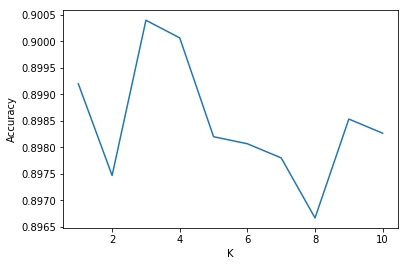

In [16]:
k = range(1,11)
plt.plot(k,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')#通过图像选择最好的参数
plt.show()

In [17]:
cv_scores

[0.8992005289333921,
 0.8974681685927595,
 0.9003992579184361,
 0.9000660577851175,
 0.8981999999999999,
 0.8980671287630143,
 0.8977999999999998,
 0.8966669065111377,
 0.8985336798963347,
 0.8982662574666211]

In [18]:
#选择最优的模型参数
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, shuffle=True)
cv_best = cross_val_score(pipe1, x_train.cutted_comment, y_train, cv=5, scoring='accuracy')
pipe2.fit(x_train.cutted_comment, y_train)#训练
x_test = vec.transform(x_test.cutted_comment)#测试集向量化
nb2_predict = nb2.predict(x_test)#保存预测结果

In [19]:
cv_best

array([0.88870377, 0.90266667, 0.89866667, 0.899     , 0.89396465])

In [20]:
#term_matrix= pd.DataFrame(vec.fit_transform(x_train.cutted_comment).toarray(), columns=vec.get_feature_names())
#term_matrix

In [22]:
scores_best = []
scores_best.append(cv_best.mean())

In [23]:
print("CountVectorizer提取的特征学习模型准确率：", scores_best)

CountVectorizer提取的特征学习模型准确率： [0.8966003507259648]


In [24]:
print("使用测试集测试使用CountVectorizer向量化模型准确率：", nb2.score(x_test, y_test))

使用测试集测试使用CountVectorizer向量化模型准确率： 0.8972


In [25]:
from sklearn import metrics#加载混淆矩阵工具
metrics.confusion_matrix(y_test, nb2_predict)

array([[2236,  195],
       [ 319, 2250]], dtype=int64)

In [26]:
from sklearn.metrics import classification_report #载入模型评估工具
print("详细的评估指标  精确率      召回率  调和均值   样本量 \n", classification_report(nb2_predict, y_test))

详细的评估指标  精确率      召回率  调和均值   样本量 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      2555
           1       0.88      0.92      0.90      2445

   micro avg       0.90      0.90      0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [27]:
#载入事件语料
pinglun = pd.read_csv('weibo_deyunse.csv', encoding='gb18030')
a = pinglun [['comment']]
a['cutted_comment'] = a.comment.apply(word_cut)
a_cout=vec.transform(a.cutted_comment)
#a.cutted_comment[:5]#评论预览
a_predict = nb2.predict(a_cout)  # 预测

In [28]:
a_predict

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [29]:
pos = str(a_predict.tolist()).count("1")
pos

3569

In [30]:
neg = str(a_predict.tolist()).count("0")
neg

3400

In [31]:
pinglun['情感倾向'] = a_predict
pinglun

,comment,情感倾向
0,小辫儿张云雷粉丝团：张云雷希望大家在追星的同时保持理智， 台上台下要分清，不要给艺人带来困扰,1
1,凝雨微甜：有的时候看到一些没买到票的女孩子们站在园子外面守候着，然后酒店机场啊，一路上的都是...,0
2,绿山墙的猪猪：保护我方德云宝贝！,0
3,奥利奥和可爱多：支持请给角儿们一个安静的生活环境 多多关注作品！,1
4,你的明欣_：关注作品 远离生活.,1
5,写九万字：追星混饭圈那一套恶臭别带进相声圈 烦死了,0
6,一位不愿透露姓名的某bear：我爱的只有杨九郎，张云雷，孟鹤堂，周九良，张九龄，王九龙，张鹤...,0
7,德云社小百科：支持维权,1
8,我不是小姐姐是肖姐姐：我每次去剧场看演出，都是安安静静的来，安安静静的走掉，既不跟踪也不在路...,0
9,德云锥鹿丷：支持 佛系捧角儿 保护我家传统艺术天团,1


In [32]:
pinglun['情感倾向'].mean()

0.5121251255560338